In [197]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [198]:
def f(x):
    return 3*x**2 - 4*x +5

In [199]:
f(3.0)

20.0

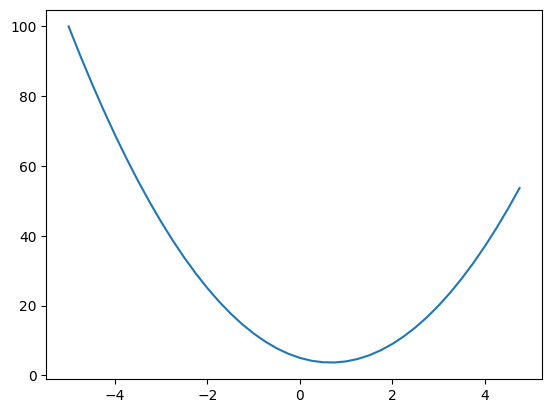

In [200]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

### Derivative

In [201]:
h = 0.000000000000001
x = 3.0

(f(x + h) - f(x)) / h  # slope

10.658141036401503

In [202]:
h = 0.000000000000001
x = -3

(f(x + h) - f(x)) / h  # slope

-14.210854715202002

In [203]:
h = 0.000000000000001
x = 2/3

(f(x + h) - f(x)) / h  # slope

0.0

In [204]:
# getting more complex

a = 2.0
b = -3.0
c = 10.0
d = a*b + c

d

4.0

In [205]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

def f(a, b, c): return a*b + c

d1 = f(a, b, c)
a += h
d_to_a = f(a, b, c)

print('d1', d1)
print('d_to_a', d_to_a)
print('slope', (d_to_a - d1) / h)

d1 4.0
d_to_a 3.999699999999999
slope -3.000000000010772


In [206]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

def f(a, b, c): return a*b + c

d1 = f(a, b, c)
b += h
d_to_b = f(a, b, c)

print('d1', d1)
print('d_to_b', d_to_b)
print('slope', (d_to_b - d1) / h)

d1 4.0
d_to_b 4.0002
slope 2.0000000000042206


In [207]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

def f(a, b, c): return a*b + c

d1 = f(a, b, c)
c += h
d_to_c = f(a, b, c)

print('d1', d1)
print('d_to_c', d_to_c)
print('slope', (d_to_c - d1) / h)

d1 4.0
d_to_c 4.0001
slope 0.9999999999976694


### First step towards neural networks

In [208]:
class Value:

    def __init__(self, data, _children = (), _op = '', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0  # derivative of the output with respect to current value, yet no effect

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        return Value(self.data + other.data, _children=(self, other), _op='+')

    def __mul__(self, other):
        return Value(self.data * other.data, _children=(self, other), _op='*')

In [209]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L  # loss function

Value(data=-8.0)

In [210]:
L._prev

{Value(data=-2.0), Value(data=4.0)}

In [211]:
L._op

'*'

In [212]:
from graphviz import Digraph

def trace(root):
    """Builds a set of all nodes and edges in a graph given the root."""
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)

    return nodes, edges

def draw_dot(root: Value):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label='{ %s | data %.4f | grad %.4f }' % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

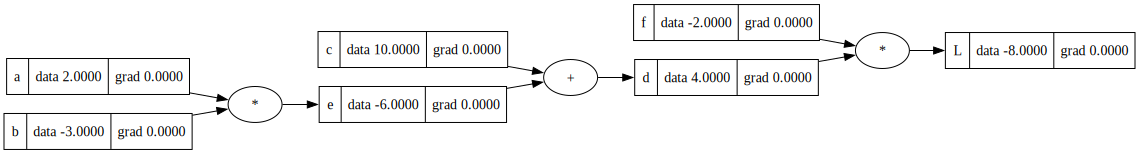

In [213]:
draw_dot(L)

```
L = d * f

dL/dd = ?

derivative
(f(x+h) - f(x)) / h

((d+h)*f - d*f) / h
(d*f + h*f - d*f) / h
(h*f)/h

f
for d * f we left with just f
```

In [214]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

In [215]:
def verify_grad():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0 + h, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)

verify_grad()

-3.9999999999995595


```
dL / dc - derivative of L with respect to c

in order to do that we should know how 'c' affects 'd'
dd / dc - derivative of d with respect to c

d = c + e
dd / dc = 1.0

(f(x+h) - f(x)) / h

we put d as x into derivative function
((c + h + e) - (c + e)) / h

(h) / h = 1

```

### The chain rule

The chain rule is a formula that expresses the derivative of the composition of two different functions. In Leibniz's annotation, if a variable z depends on the variable y, which itself depends on the variable x (that is, y and z are dependent variables) then z depends on x as well, via the intermediate variable y. In this case, the chain rule is expressed as
```
dz/dx = dz/dy * dy/dx
```

George F. Simmons
> If a car travels twice as fast as bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 x 4 = 8 times as fast as the man.

```
dL/dc = dL/dd * dd/dc

We already know dL/dd = -2.0 and dd/dc = 1.0, so dL/dc = -2.0 * 1.0
```

In [216]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0

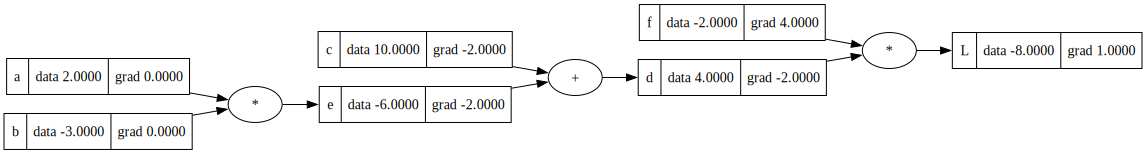

In [217]:
draw_dot(L)

```
To calculate dL/da, we apply the same chain rule. That is dL/da = dL/de * de/da.

We already know dL/de (e.grad) is -2.0, now we need to calculate de/da.

e = a * b

de/da = ?

derivative
(f(x+h) - f(x)) / h

(((a+h) * b) - a*b) / h
(a*b + h*b - a*b) / h
(h*b) / h
b = -3.0

So, dL/da = -2.0 * -3.0

That gives dL/da = 6

From this we can calculate dL/db = dL/de * de/db
de/db = 2.0 if we use above algorithm.

That gives dL/db = -2.0 * 2.0, so dL/db = -4.0
```

In [218]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6
b.grad = -4.0

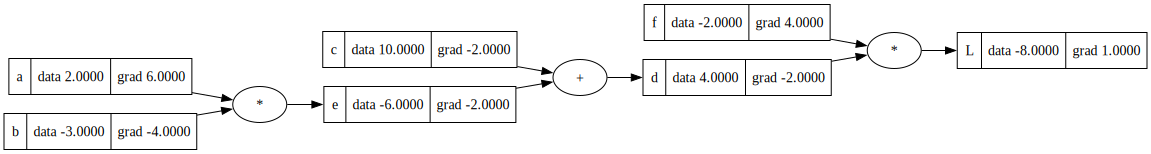

In [219]:
draw_dot(L)

### Backpropagation

Backpropagation is recursive application of chain rule backwards using local derivatives.

In [220]:
# let's try to make L go up, by increasing value of leaf nodes over which we have control
h = 0.01
a.data += h * a.grad
b.data += h * b.grad
c.data += h * c.grad
f.data += h * f.grad

# we run forward path again
e = a * b
d = e + c
L = f * d

# we expect value of L go up positively, and that will be one step of optimization
L

Value(data=-7.286496)

### A bit more complex backpropagation

In a simple neural network there is an input layer and multiple hidden layers made up of neurons which are fully connected to each other. In comparison to bilogical neurons, we have very simple mathematical models of neurons. In which we have some input `x` and then we have synapses with weights `w`. Input comes to synapse and will be mutiplicated by synapse's weight - `w*x`, there are multiple inputs and synapses which all flow into cell body. Cell body has some bias `b`, so the sum of all `w*x` plus bias `b` which makes result of cell body adjustable to the activation level regardless of the input. Then we push it into activation function, it is usually some kind of squashing function like a sigmoid or tanh. Activation function basically determines how much and whether at all neuron's signal will contribute to the next layer.

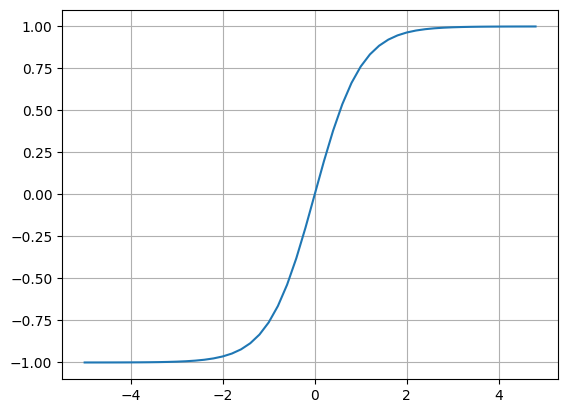

In [221]:
# tanh as plot
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

From the plot above, we can see that tanh function smoothes out any input in range of -1.0 and 1.0, and at 0 it's result is also 0. That's the example of the activation function. So the result of a neuron is activation function applied to the product of inputs and weights.

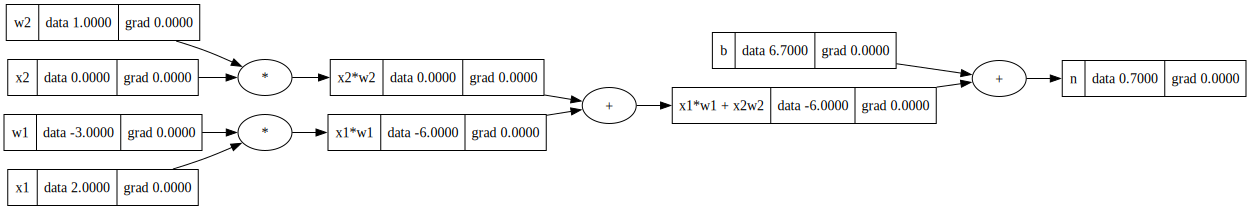

In [222]:
# now we can see how a bit more complex case of backprpagation works for a neuron

# inputs: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.7, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2w2'
# n is raw activation without activation function
n = x1w1x2w2 + b; n.label = 'n'

draw_dot(n)

In [223]:
# now we need activation function, for that we need to implement tanh in our Value class

class Value:

    def __init__(self, data, _children = (), _op = '', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0  # derivative of the output with respect to current value, yet no effect

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        return Value(self.data + other.data, _children=(self, other), _op='+')

    def __mul__(self, other):
        return Value(self.data * other.data, _children=(self, other), _op='*')

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        return Value(t, _children=(self, ), _op='tanh')

In [224]:
# let's add that activation function to our neuron

# inputs: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function applied
o = n.tanh(); o.label = 'o'

This is a simple neuron which typically would be part of a larger net. Most interesting for us is gradients for weights, cause we will tweak those in order to improve accuracy which is measured by a loss function for the whole neural network.

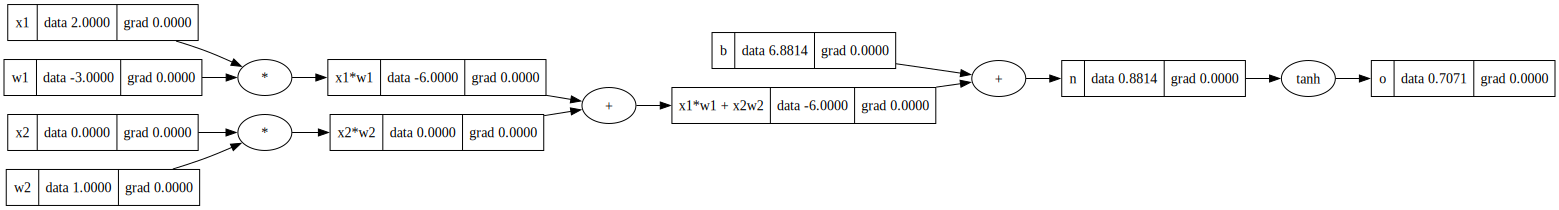

In [225]:
draw_dot(o)

In [226]:
# now let's calculate gradients
o.grad = 1.0

# derivative function: (f(x+h) - f(x)) / h

# do/dn
# o = tanh(n)
# Wikipedia tells us that derivative of tanh(x) = 1 - tanh(x)**2
# that means do/dn = 1 - o**2, if we use chain rule here it is do/dn = (1 - o**2) * dn/dn
# do/dn = 1 - o.data ** 2 = 1 - 0.7071067811865476 ** 2 = 0.4999999999999999
n.grad = 0.4999999999999999

# do/x1w1x2w2
# If we apply the chain rule here, we get do/x1w1x2w2 = do/dn * dn/dx1w1x2w2
# We know do/dn = 0.5, now we should calculate dn/dx1w1x2w2
# dn/dx1w1x2w2 = ((x1w1x2w2 + b + h) - (x1w1x2w2 + b)) / h
# dn/dx1w1x2w2 = h / h = 1
# dn/dx1w1x2w2 = 1
# Now we can calculate do/x1w1x2w2 = do/dn * dn/dx1w1x2w2 = n.grad * 1 = 0.5
x1w1x2w2.grad = 0.5
# Same applies for b due to similarity
b.grad = 0.5

# That means, when it is sum operation we just inherit grad of the parent, applying this we get derivatives for x2w2 and x1w1
x2w2.grad = 0.5
x1w1.grad = 0.5

# Now let's calculate grads for x2, w2, x1, w1
# do/dx2 = do/x2w2 * dx2w2/dx2, chain rule it is
# do/dx2 = 0.5 * dx2w2/dx2
# We need dx2w2/dx2, that is ((x2 * w2 + h) - (x2*w2)) / h if we put it in derivative function
# dx2w2/dx2 = (((x2 + h) * w2) - (x2 * w2)) / h
# dx2w2/dx2 = ((w2*x2 + w2*h) - x2*w2) / h
# dx2w2/dx2 = w2 * h / h
# dx2w2/dx2 = w2 (w2.data)
# dx2w2/dx2 = 1

# do/dx2 = 0.5 * 1
# do/dx2 = 0.5
x2.grad = 0.5

# That means for each multiplication, we take resulting grad and multiply it with value of other. And we can apply this to other values
# w2.grad = do/dx2w2 * x2 = x2w2.grad * x2.data = 0.5 * 0
w2.grad = 0
# x1.grad = do/dx1w1 * w1 = x1w1.grad * w1.data = 0.5 * -3
x1.grad = -1.5
# w1.grad = do/dx1w1 * x1 = x1w1.grad * x1.data = 0.5 * 2.0
w1.grad = 1.0

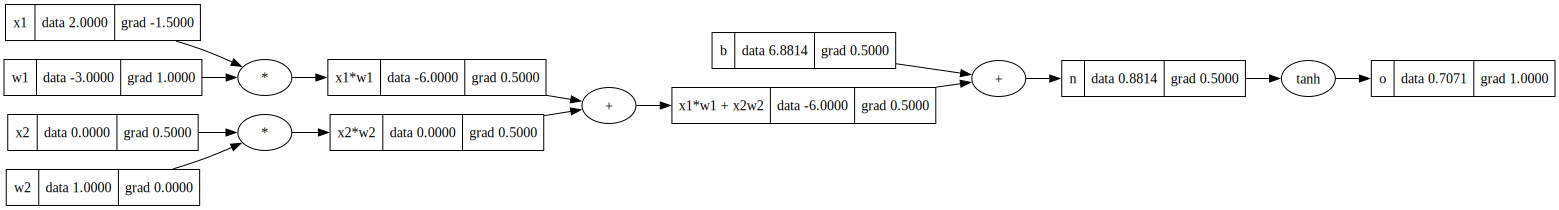

In [227]:
draw_dot(o)

### Implementing backpropagation

In [228]:
class Value:

    def __init__(self, data, _children = (), _op = '', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None

        self.label = label
        self.grad = 0.0  # derivative of the output with respect to current value, yet no effect

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        def _backward(): self.grad = 1 * out.grad; other.grad = 1 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        def _backward(): self.grad = out.grad * other.data; other.grad = out.grad * self.data

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, _children=(self, ), _op='tanh')

        def _backward(): self.grad = 1 - (out.data ** 2) * out.grad

        out._backward = _backward
        return out

In [229]:
# inputs: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function applied
o = n.tanh(); o.label = 'o'

In [230]:
# we need to set grad for o manually
o.grad = 1.0

In [231]:
o._backward()

In [232]:
n._backward()

In [233]:
b._backward()
x1w1x2w2._backward()

In [234]:
x1w1._backward()

In [235]:
x2w2._backward()

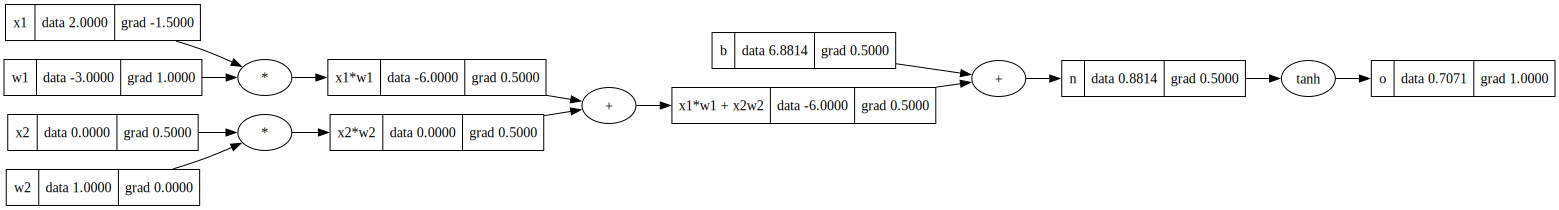

In [236]:
draw_dot(o)

We have implemented backpropagation, but yet we calling it on each node that has dependencies. In order to get rid of that, we wanna call `._backward()` on each node that has dependencies. And important thing here is order of function calls, that means we must call `.backward()` first on nodes on which current node depends. To do that we can use `Topological Sort`.

Basically, how topological sort works is that we want to build a list of nodes where all the nodes are sorted based on dependencies. So current node is last in the list and it's dependencies are earlier and their dependencies are even earlier, etc.

In [237]:
# imlementation of topological sort for our Value class
topo = []
visited = set()

def build_topo(node):
    if node not in visited:
        visited.add(node)
        for child in node._prev:
            build_topo(child)  # first add children nodes
        topo.append(node)  # then add current node

build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

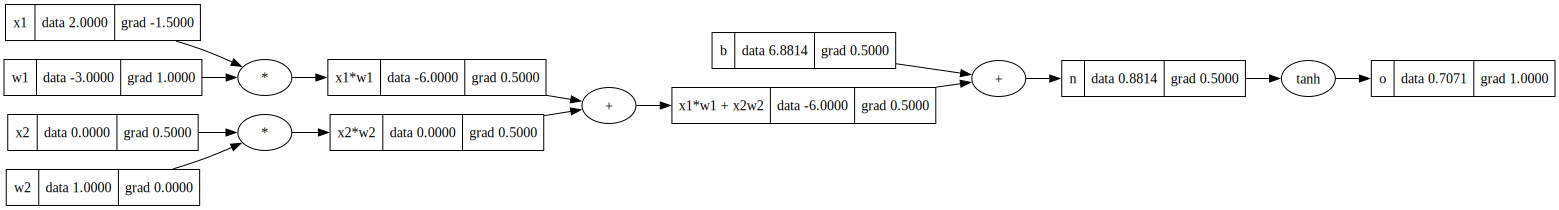

In [238]:
draw_dot(o)

In [239]:
for node in reversed(topo):  # call .backwards on each node starting from least to most dependant
    node._backward()

In [240]:
# now we can implement public backward method for our Value class

class Value:

    def __init__(self, data, _children = (), _op = '', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None

        self.label = label
        self.grad = 0.0  # derivative of the output with respect to current value, yet no effect

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        def _backward(): self.grad = 1 * out.grad; other.grad = 1 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        def _backward(): self.grad = out.grad * other.data; other.grad = out.grad * self.data

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, _children=(self, ), _op='tanh')

        def _backward(): self.grad = 1 - (out.data ** 2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_topo(child)
                topo.append(node)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [241]:
# let's reinitialize and call our backward method

# inputs: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function applied
o = n.tanh(); o.label = 'o'

# backpropagation
o.backward()

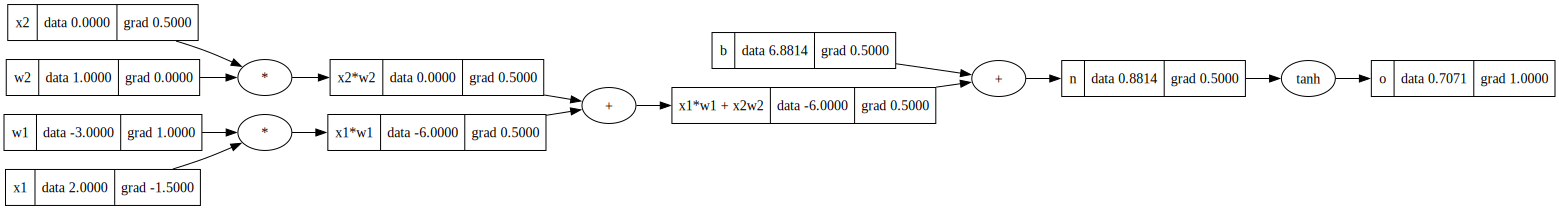

In [242]:
draw_dot(o)

### Current implementation of Value class can serve us right only when we use one variable only one time

The proble here is that once we use Value more than one time it will always override grad with last operation's derivative. Instead we should sum gradients up, according to multivariable case of the chain rule. So let's adjust our implementation, so our grad value is accumulative.

In [243]:
# case of the problem, with incorrect gradients

a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()  # grads of a and b are incorrect

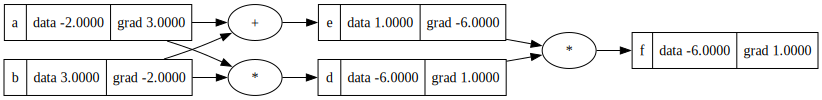

In [244]:
draw_dot(f)

In [245]:
# implementation with consideration of multivariable case of the chain rule

class Value:

    def __init__(self, data, _children = (), _op = '', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None

        self.label = label
        self.grad = 0.0  # derivative of the output with respect to current value, yet no effect

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        def _backward(): self.grad += 1 * out.grad; other.grad += 1 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        def _backward(): self.grad += out.grad * other.data; other.grad += out.grad * self.data

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, _children=(self, ), _op='tanh')

        def _backward(): self.grad += 1 - (out.data ** 2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_topo(child)
                topo.append(node)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [246]:
# all gradients are correct

a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

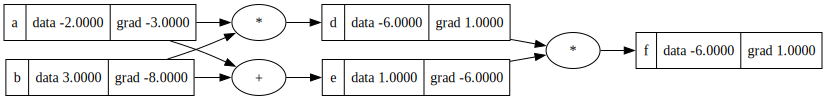

In [247]:
draw_dot(f)

### Implementing tanh as atomic operations

In [248]:
# for now we can't do things like Value(2.0) + 1, cause 1 is not Value instance, so let's fix that for convenience

class Value:

    def __init__(self, data, _children = (), _op = '', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None

        self.label = label
        self.grad = 0.0  # derivative of the output with respect to current value, yet no effect

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        def _backward(): self.grad += 1 * out.grad; other.grad += 1 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        def _backward(): self.grad += out.grad * other.data; other.grad += out.grad * self.data

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward(): self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward

        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, _children=(self, ), _op='tanh')

        def _backward(): self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        exp_x = math.exp(self.data)
        out = Value(exp_x, (self,), 'exp')

        def _backward(): self.grad += exp_x * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_topo(child)
                topo.append(node)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [249]:
a = Value(2.0) + 1
b = Value(3.0) * 2
c = 2 * Value(3.0)
d = Value(2.0).exp()

e = Value(2.0)
f = Value(4.0)
g = e / f

h = Value(3.0) - Value(1.0)

a, b, c, d, g, h

(Value(data=3.0),
 Value(data=6.0),
 Value(data=6.0),
 Value(data=7.38905609893065),
 Value(data=0.5),
 Value(data=2.0))

### Now that we have implemented division, exp, pow and subtraction we can rewrite tanh using it's formula

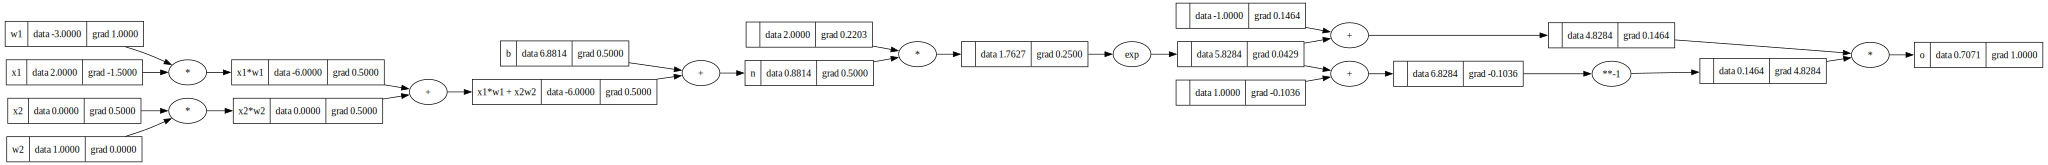

In [250]:
# let's reinitialize and call our backward method

# inputs: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function applied, now tanh implemented using formula
nexp = (2*n).exp()
o = (nexp - 1) / (nexp + 1)
o.label = 'o'

# backpropagation
o.backward()

# we should see that all resulting gradients are the same
draw_dot(o)

### Doing the same thing, but using PyTorch this time

In [251]:
import torch

# cause we are using singular scalar value of float64, we need to convert tensors data types
# also by default PyTorch does not calculate gradients for leaf nodes, so we also explicitly state that
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Let's start building our neural network: two-layer multilayer perceptron

In [252]:
import random


class Neuron:

    def __init__(self, nin: int):  # number of inputs
        # weight
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        # bias
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x: list[float | int]):
        # w * x + b: raw activation function
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), start=self.b)
        # pass the activation through a non-linearity, or in other words normalize it, so result is -1 <= x <= 1
        out = activation.tanh()
        return out


class Layer:

    def __init__(self, nin, nout):
        # nin - number of inputs
        # nout - number of outputs, how many neurons do we want in the layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x: list[float | int]):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs


class MLP:  # multilayer perceptron

    def __init__(self, nin, nouts):
        # nin - number of inputs
        # nouts - list of nouts, this list defines sizes of all the layers that we want in the mlp
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x: list[float | int]):
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8811610143308144)

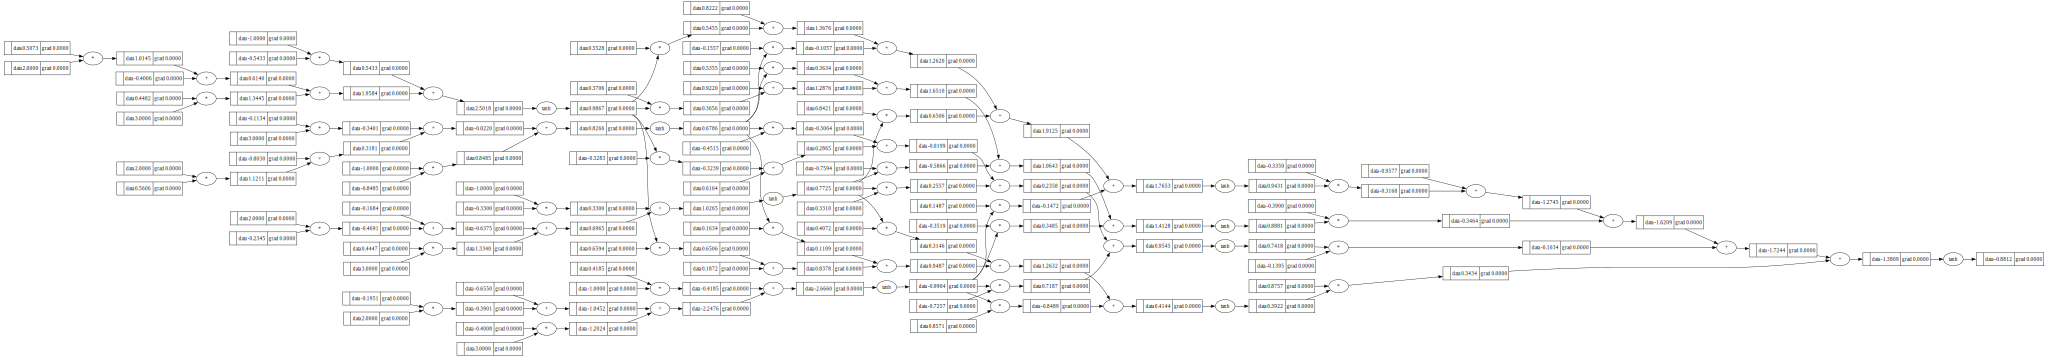

In [253]:
draw_dot(n(x))

In [254]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# ys - describes desired target value for each array in xs matrix
ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.8811610143308144),
 Value(data=-0.9350694977896082),
 Value(data=-0.9667709164932476),
 Value(data=-0.9202067445249492)]

Now, our neural net's output is not even close to our target values. So we want to fine-tune this, basically saying to adjust our weights so that result meets our target values. The trick used in deep learning to achieve this is to calculate a single number that measures total performance of a neural net, and that single number is the loss.

So in our case loss will be high, cause we are off our target values.

In [255]:
# mean square error loss - what this does is shows our actual loss for each target value removing the sign
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=3.5387667618381387),
 Value(data=0.004215970117293689),
 Value(data=0.0011041719906987213),
 Value(data=3.6871939417191033)]

In [256]:
# so the final loss is just the sum of losses for each target value
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=7.231280845665235)

In [257]:
# now we want to minimize our loss, to understand how to do that we can backpropagate through the loss
loss.backward()

In [258]:
print(n.layers[0].neurons[0].w[0])
print(n.layers[0].neurons[0].w[0].grad)
# this shows how the neuron's weight is affecting the loss

Value(data=0.5072636557285557)
-0.11471996230400704


In order to tweak our weights and biases, we want to get access to them, so let's implement that

In [259]:
class Neuron:

    def __init__(self, nin: int):  # number of inputs
        # weight
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        # bias
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x: list[float | int]):
        # w * x + b: raw activation function
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), start=self.b)
        # pass the activation through a non-linearity, or in other words normalize it, so result is -1 <= x <= 1
        out = activation.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:

    def __init__(self, nin, nout):
        # nin - number of inputs
        # nout - number of outputs, how many neurons do we want in the layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x: list[float | int]):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons: params.extend(neuron.parameters())
        return params


class MLP:  # multilayer perceptron

    def __init__(self, nin, nouts):
        # nin - number of inputs
        # nouts - list of nouts, this list defines sizes of all the layers that we want in the mlp
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x: list[float | int]):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for layer in self.layers: params.extend(layer.parameters())
        return params

In [260]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8255745295065016)

In [261]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# ys - describes desired target value for each array in xs matrix
ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data=0.8255745295065016),
 Value(data=0.9461237683661438),
 Value(data=0.9207076228686163),
 Value(data=0.781208291153481)]

In [262]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=7.5548095509621085)

In [263]:
loss.backward()

In [264]:
# so now we can get all parameters of the mlp
n.parameters()

[Value(data=0.5375728271883313),
 Value(data=0.02728299755117458),
 Value(data=0.7206199222053347),
 Value(data=0.8925905151052504),
 Value(data=0.5005371824098286),
 Value(data=0.2095484766067739),
 Value(data=0.31777931988818775),
 Value(data=-0.24834429113501977),
 Value(data=-0.0851881515011419),
 Value(data=-0.2525206076019877),
 Value(data=0.6284654916023125),
 Value(data=-0.08325992916669955),
 Value(data=-0.5117323103115508),
 Value(data=-0.4658785465701276),
 Value(data=0.9266456255872664),
 Value(data=-0.6118723811192137),
 Value(data=0.6147965523026264),
 Value(data=0.44897903972313014),
 Value(data=0.7081603315441496),
 Value(data=-0.15902152629302524),
 Value(data=0.7116924663032862),
 Value(data=0.642968410677625),
 Value(data=-0.32108270155782237),
 Value(data=-0.684970153616713),
 Value(data=0.37593204155144444),
 Value(data=-0.8027403911798867),
 Value(data=0.9123084439041709),
 Value(data=0.046337603120190085),
 Value(data=0.7502357958629333),
 Value(data=0.6601938336

### Gradient Descent

Now we can start changing parameters according to their gradient to minimize our loss. That also means that we can apply gradient descent to our weights, to iteratively get to minimal loss. In gradient descent we are thinking of gradients as a vector pointing towards increasing the loss. So we are iteratively modifying the vector by small step size in the direction of the gradient.

In [265]:
print(loss)
print(n.layers[0].neurons[0].w[0])
print(n.layers[0].neurons[0].w[0].grad)

Value(data=7.5548095509621085)
Value(data=0.5375728271883313)
-0.07172497242989108


In [266]:
for p in n.parameters():
    p.data += 0.001 * p.grad

In [267]:
# forward pass
ypred = [n(x) for x in xs]

# backward pass
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss.backward()

In [268]:
print('loss', loss)
print('weight', n.layers[0].neurons[0].w[0])
print('grad', n.layers[0].neurons[0].w[0].grad)

loss Value(data=7.558476880689401)
weight Value(data=0.5375011022159014)
grad -0.14344818567070008


In [269]:
# target values
ys

[1.0, -1.0, -1.0, 1.0]

In [270]:
# what we are getting
ypred

[Value(data=0.8260535338483112),
 Value(data=0.946533347191415),
 Value(data=0.9213261667188537),
 Value(data=0.7815207173300832)]

Manual Gradient Descent

In [271]:
# Let's do gradient descent manually

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

In [272]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# ys - describes desired target value for each array in xs matrix
ys = [1.0, -1.0, -1.0, 1.0]

In [282]:
for k in range(30):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # backward pass
    # don't forget to reset gradients before doing backward pass
    # to correctly recalculate grads
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.008080565247986575
1 0.007966788586012592
2 0.007856023400122836
3 0.007748153851756483
4 0.007643069910459963
5 0.007540666996578535
6 0.007440845649896192
7 0.007343511222058029
8 0.007248573590813473
9 0.007155946894300353
10 0.0070655492837540055
11 0.006977302693172576
12 0.006891132624600874
13 0.006806967947815372
14 0.006724740713298526
15 0.006644385977488979
16 0.006565841639379722
17 0.006489048287617015
18 0.006413949057322749
19 0.00634048949592915
20 0.006268617437372545
21 0.006198282884046646
22 0.006129437895964399
23 0.00606203648662148
24 0.005996034525095116
25 0.005931389643947536
26 0.005868061152538551
27 0.005806009955380852
28 0.0057451984751998066
29 0.005685590580386204


In [283]:
ypred

[Value(data=0.9654720268207866),
 Value(data=-0.9747324643301803),
 Value(data=-0.9521599085912176),
 Value(data=0.9604236567670097)]

In [284]:
ys

[1.0, -1.0, -1.0, 1.0]

Finally, we can see that our predictions are very similar to our desired targets